<h3>7.2前向传播与随时间反向传播</h3>

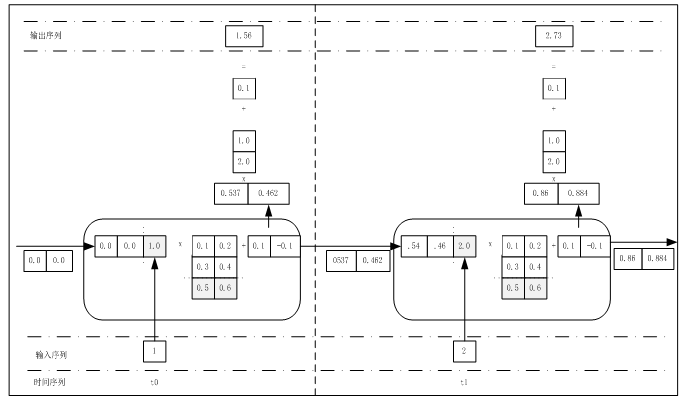

In [2]:
import numpy as np

X = [1,2]
state = [0.0, 0.0]
w_cell_state = np.asarray([[0.1, 0.2], [0.3, 0.4],[0.5, 0.6]])
b_cell = np.asarray([0.1, -0.1])
w_output = np.asarray([[1.0], [2.0]])
b_output = 0.1

for i in range(len(X)):
    state=np.append(state,X[i])
    before_activation = np.dot(state, w_cell_state) + b_cell
    state = np.tanh(before_activation)
    final_output = np.dot(state, w_output) + b_output
    print("状态值_%i: "%i, state)
    print("输出值_%i: "%i, final_output)


状态值_0:  [0.53704957 0.46211716]
输出值_0:  [1.56128388]
状态值_1:  [0.85973818 0.88366641]
输出值_1:  [2.72707101]


<h3>7.4 循环神经网络的Pytorch实现</h3>

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [7]:
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

In [8]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # LSTM以word_embeddings作为输入, 输出维度为 hidden_dim 的隐藏状态值
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # 线性层将隐藏状态空间映射到标注空间
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # 一开始并没有隐藏状态所以我们要先初始化一个
        # 关于维度为什么这么设计请参考Pytoch相关文档
        # 各个维度的含义是 (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(1, 1, self.hidden_dim),
                torch.zeros(1, 1, self.hidden_dim))

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, self.hidden = self.lstm(
            embeds.view(len(sentence), 1, -1), self.hidden)
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [9]:
rnn = nn.RNN(input_size=10, hidden_size=20,num_layers= 2)

In [10]:
print("wih形状{},whh形状{},bih形状{}".format(rnn.weight_ih_l0.shape,rnn.weight_hh_l0.shape,rnn.bias_hh_l0.shape))

wih形状torch.Size([20, 10]),whh形状torch.Size([20, 20]),bih形状torch.Size([20])


In [12]:
input=torch.randn(100,32,10)
h_0=torch.randn(2,32,20)

In [13]:
output,h_n=rnn(input,h_0)
print(output.shape,h_n.shape)

torch.Size([100, 32, 20]) torch.Size([2, 32, 20])


In [14]:
rnn_cell = nn.RNNCell(input_size=10, hidden_size=20)

input_cell=torch.randn(100,32,10)

h_cell_0=torch.randn(32,20)
output = []



In [18]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
#rnn = RNN(n_letters, n_hidden, n_categories)

In [19]:
import torch.nn as nn
import torch

class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, cell_size, output_size):
        super(LSTMCell, self).__init__()
        self.hidden_size = hidden_size
        self.cell_size = cell_size
        self.gate = nn.Linear(input_size + hidden_size, cell_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell):
        combined = torch.cat((input, hidden), 1)
        f_gate = self.sigmoid(self.gate(combined))
        i_gate = self.sigmoid(self.gate(combined))
        o_gate = self.sigmoid(self.gate(combined))
        z_state = self.tanh(self.gate(combined))
        cell = torch.add(torch.mul(cell, f_gate), torch.mul(z_state, i_gate))
        hidden = torch.mul(self.tanh(cell), o_gate)
        output = self.output(hidden)
        output = self.softmax(output)
        return output, hidden, cell

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

    def initCell(self):
        return torch.zeros(1, self.cell_size)

In [20]:
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUCell, self).__init__()
        self.hidden_size = hidden_size
        self.gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)        
        z_gate = self.sigmoid(self.gate(combined))
        r_gate = self.sigmoid(self.gate(combined))
        combined01 = torch.cat((input, torch.mul(hidden,r_gate)), 1)  
        h1_state = self.tanh(self.gate(combined01))
        
        h_state = torch.add(torch.mul((1-z_gate), hidden), torch.mul(h1_state, z_gate))
        output = self.output(h_state)
        output = self.softmax(output)
        return output, h_state

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)    

In [22]:
grucell = GRUCell(input_size=10,hidden_size=20,output_size=10)

In [132]:
import torch.nn as nn

In [154]:
grucell = GRUCell(input_size=10,hidden_size=20,output_size=10)

In [23]:
input=torch.randn(32,10)
h_0=torch.randn(32,20)

output,hn=grucell(input,h_0)
print(output.size(),hn.size())

torch.Size([32, 10]) torch.Size([32, 20])
